
#  Prophet  Station de **Gombele**

je propose ici le code qui permet de justifier l'automatisation de la station de pompage à partir des données historique que j'ai directement extrait de la sttation de gombele, le code que je fournit fait ceci:
 lit `efficacite_ds_y.xlsx` qui est le fichier sur lequel j'ai calculer la donner cible qu'on vas utiliser  dans ce code ici
 
- applique une **winsorisation** (cap des extrêmes) pour robustifier,
- cherche des **hyperparamètres** Prophet sur une **grille sobre**,
- fait une **validation croisée**; si elle échoue, il bascule sur un **fallback** d'évaluation *in-sample*,
- **sélectionne** le modèle selon un **score** (précision + largeur des bandes),
- **prévoit** et calcule le **risque** d'être sous une **cible** (quantile ou fixe),
- exporte un **rapport** + un **fichier Excel** de la prévision.

**Corrections incluses** pour éviter `KeyError: 'score'` quand la grille est vide.


## 2) Imports & Paramètres

In [1]:

from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# === FICHIERS ===
INPUT_XLSX = Path("efficacite_ds_y.xlsx")
SHEET_NAME = 0

# === HORIZON ===
FORECAST_HORIZON = 90  # jours

# === CIBLE (risque) ===
TARGET_MODE = "quantile"   # "quantile" ou "fixed"
TARGET_Q    = 0.65
TARGET_FIX  = 1.90

# === WINSOR ===
WINSOR_LO = 0.01
WINSOR_HI = 0.99
DROP_NAN  = True

# === CV défaut ===
CV_INITIAL_DEFAULT = "365 days"
CV_PERIOD_DEFAULT  = "30 days"
CV_HORIZON_DEFAULT = "90 days"

# === Grille d'hyperparamètres (sobre) ===
GRID_BASE = [
    {"cps": 0.2, "mode": "additive",      "sps": 5},
    {"cps": 0.2, "mode": "additive",      "sps": 10},
    {"cps": 0.3, "mode": "additive",      "sps": 10},
    {"cps": 0.5, "mode": "additive",      "sps": 10},
    {"cps": 0.3, "mode": "multiplicative","sps": 10},
    {"cps": 0.5, "mode": "multiplicative","sps": 10},
]

# === Score (à minimiser) ===
W_MAPE = 0.7
W_BAND = 0.3

# === Affichage ===
ROLLING_WINDOW = 14


## 3) Chargement, contrôle & winsorisation (robuste)

In [2]:

df = pd.read_excel(INPUT_XLSX, sheet_name=SHEET_NAME)
df.columns = [str(c).strip().lower() for c in df.columns]

if not set(["ds","y"]).issubset(df.columns):
    raise ValueError("Le fichier doit contenir au moins les colonnes 'ds' et 'y'.")

df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
df["y"]  = pd.to_numeric(df["y"], errors="coerce")
if DROP_NAN:
    df = df.dropna(subset=["ds","y"]).copy()
else:
    df = df.dropna(subset=["ds"]).copy()
    df["y"] = df["y"].fillna(0.0)

df = df.sort_values("ds").reset_index(drop=True)

print("Lignes:", len(df))
print("Période:", df["ds"].min().date(), "→", df["ds"].max().date())

# Winsorisation pour limiter l'impact des extrêmes
y_lo = df["y"].quantile(WINSOR_LO)
y_hi = df["y"].quantile(WINSOR_HI)
df["y_winz"] = df["y"].clip(lower=y_lo, upper=y_hi)
dfm = df[["ds","y_winz"]].rename(columns={"y_winz":"y"}).copy()

print(f"Winsor: bas={y_lo:.4f}, haut={y_hi:.4f}")


Lignes: 855
Période: 2020-11-03 → 2025-08-27
Winsor: bas=0.0000, haut=9.3774


## 4) Cible d'efficacité & CV adaptatif (avec garde-fous)

In [3]:

# Cible pour le calcul de risque
if TARGET_MODE == "quantile":
    target_eff = float(dfm["y"].quantile(TARGET_Q))
elif TARGET_MODE == "fixed":
    target_eff = float(TARGET_FIX)
else:
    raise ValueError("TARGET_MODE doit être 'quantile' ou 'fixed'.")
print("Cible (m³/kWh) =", round(target_eff, 4))

# Fenêtres CV bornées par la durée réelle
span_days = max(1, (dfm["ds"].max() - dfm["ds"].min()).days + 1)
# Horizon max = min(FORECAST_HORIZON, 0.25*span, 120), min 30
hori_days = max(30, min(int(FORECAST_HORIZON), int(0.25*span_days), 120))
# Initial >= horizon + 30, et <= 0.8*span
init_days = max(hori_days + 30, min(int(0.8*span_days), max(180, int(0.6*span_days))))  # compromis sûr
# Period ~ horizon/3 (entre 14 et 45)
period_days = min(45, max(14, int(hori_days/3)))

if span_days < 120:
    # Série courte: valeurs par défaut
    CV_INITIAL = CV_INITIAL_DEFAULT
    CV_HORIZON = CV_HORIZON_DEFAULT
    CV_PERIOD  = CV_PERIOD_DEFAULT
else:
    CV_INITIAL = f"{init_days} days"
    CV_HORIZON = f"{hori_days} days"
    CV_PERIOD  = f"{period_days} days"

print("CV windows -> initial:", CV_INITIAL, "| period:", CV_PERIOD, "| horizon:", CV_HORIZON)


Cible (m³/kWh) = 1.3511
CV windows -> initial: 1055 days | period: 30 days | horizon: 90 days


## 5) Fonctions utilitaires — évaluation fallback si la CV échoue

In [4]:

def safe_mape(y_true, y_pred, eps=1e-6):
    import numpy as np
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom))

def evaluate_model_with_fallback(model, dfm, cv_initial, cv_period, cv_horizon):
    """Tente une cross_validation Prophet.
    Si ça échoue, effectue une évaluation *in-sample* :
      - prédit sur l'historique, calcule une MAPE robuste
      - calcule une largeur relative moyenne des bandes
    Retourne (mape, band_rel, used_cv: bool)
    """
    from prophet.diagnostics import cross_validation, performance_metrics
    import numpy as np
    import pandas as pd

    try:
        df_cv = cross_validation(model, initial=cv_initial, period=cv_period, horizon=cv_horizon, parallel=None)
        df_pm = performance_metrics(df_cv)
        mape = float(df_pm["mape"].mean())
        band = (df_cv["yhat_upper"] - df_cv["yhat_lower"]).abs()
        scale = float(dfm["y"].median()) or float(dfm["y"].mean()) or 1.0
        band_rel = float(band.mean()) / scale
        return mape, band_rel, True
    except Exception as e:
        print("⚠️ CV échouée, fallback in-sample ->", e)

    fc_hist = model.predict(dfm[["ds"]])
    merged = pd.merge(dfm, fc_hist[["ds","yhat","yhat_lower","yhat_upper"]], on="ds", how="inner")
    mape = safe_mape(merged["y"].values, merged["yhat"].values)
    band = (merged["yhat_upper"] - merged["yhat_lower"]).abs()
    scale = float(dfm["y"].median()) or float(dfm["y"].mean()) or 1.0
    band_rel = float(band.mean()) / scale
    return mape, band_rel, False


## 6) Grille d'hyperparamètres filtrée si y ≤ 0 (multiplicatif incompatible)

In [5]:

GRID = GRID_BASE.copy()
if (dfm["y"] <= 0).any():
    GRID = [g for g in GRID if g["mode"] == "additive"]
    print("🔎 y ≤ 0 détecté → on retire les configs 'multiplicative'.")
print("Taille grille:", len(GRID))


🔎 y ≤ 0 détecté → on retire les configs 'multiplicative'.
Taille grille: 4


## 7) Recherche d'hyperparamètres + sélection robuste

In [6]:

results = []
best = None

for g in GRID:
    cps, mode, sps = g["cps"], g["mode"], g["sps"]
    try:
        m = Prophet(
            seasonality_mode=mode,
            yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            interval_width=0.95
        )
        m.fit(dfm[["ds","y"]])

        mape, band_rel, used_cv = evaluate_model_with_fallback(m, dfm, CV_INITIAL, CV_PERIOD, CV_HORIZON)
        score = W_MAPE*mape + W_BAND*(band_rel if not math.isnan(band_rel) else 1.0)
        res = {"cps": cps, "mode": mode, "sps": sps, "mape": mape, "band_rel": band_rel, "score": score, "used_cv": used_cv}
        results.append(res)

        if (best is None) or (score < best["score"]):
            best = res

    except Exception as e:
        print(f"⚠️ Échec config {g}: {e}")

df_res = pd.DataFrame(results)
if df_res.empty:
    print("⚠️ Aucune configuration évaluée. Fallback conservateur.")
    best = {"cps": 0.3, "mode": "additive", "sps": 10, "mape": float('nan'), "band_rel": float('nan'), "score": float('inf'), "used_cv": False}
else:
    df_res = df_res.sort_values("score").reset_index(drop=True)
    print("Configurations testées (triées par SCORE croissant):")
    display(df_res)

print("Meilleurs hyperparamètres:", best)


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/19 [00:00<?, ?it/s]

12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:19 - cmdstanpy - INFO - Chain [1] done processing
12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing
12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing
12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing
12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23 - cmdstanpy - INFO - Chain [1] done processing
12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing
12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1]

⚠️ CV échouée, fallback in-sample -> 'mape'


12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/19 [00:00<?, ?it/s]

12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:35 - cmdstanpy - INFO - Chain [1] done processing
12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing
12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing
12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing
12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing
12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:38 - cmdstanpy - INFO - Chain [1] done processing
12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing
12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1]

⚠️ CV échouée, fallback in-sample -> 'mape'


12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/19 [00:00<?, ?it/s]

12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing
12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing
12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing
12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing
12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing
12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1]

⚠️ CV échouée, fallback in-sample -> 'mape'


12:45:59 - cmdstanpy - INFO - Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/19 [00:00<?, ?it/s]

12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:00 - cmdstanpy - INFO - Chain [1] done processing
12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:00 - cmdstanpy - INFO - Chain [1] done processing
12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing
12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing
12:46:02 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing
12:46:02 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing
12:46:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:05 - cmdstanpy - INFO - Chain [1]

⚠️ CV échouée, fallback in-sample -> 'mape'
Configurations testées (triées par SCORE croissant):


,cps,mode,sps,mape,band_rel,score,used_cv
0,0.5,additive,10,265190.565564,6.347839,185635.300246,False
1,0.3,additive,10,285823.298728,6.488351,200078.255615,False
2,0.2,additive,5,290476.507953,6.557306,203335.522759,False
3,0.2,additive,10,291331.238807,6.576846,203933.840219,False


Meilleurs hyperparamètres: {'cps': 0.5, 'mode': 'additive', 'sps': 10, 'mape': 265190.56556385173, 'band_rel': 6.347839141788566, 'score': 185635.30024643874, 'used_cv': False}


## 8) Entraînement final & Prévision

In [7]:

m_final = Prophet(
    seasonality_mode=best["mode"],
    yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
    changepoint_prior_scale=best["cps"],
    seasonality_prior_scale=best["sps"],
    interval_width=0.95
)
m_final.fit(dfm[["ds","y"]])

future = m_final.make_future_dataframe(periods=int(FORECAST_HORIZON), freq="D")
forecast = m_final.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()


12:46:14 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
940,2025-11-21,3.140035,0.218359,6.019753
941,2025-11-22,2.810079,0.067815,5.743810
942,2025-11-23,3.262020,0.727663,6.139249
943,2025-11-24,3.055110,0.148767,5.931328
944,2025-11-25,2.996659,0.110781,5.661116


### 8.1) Graphiques

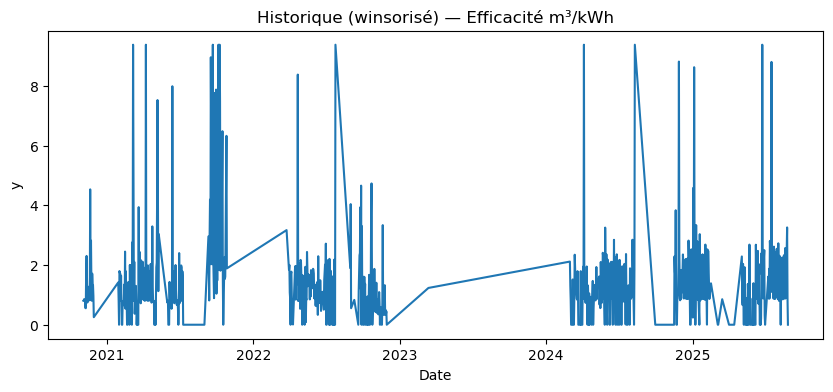

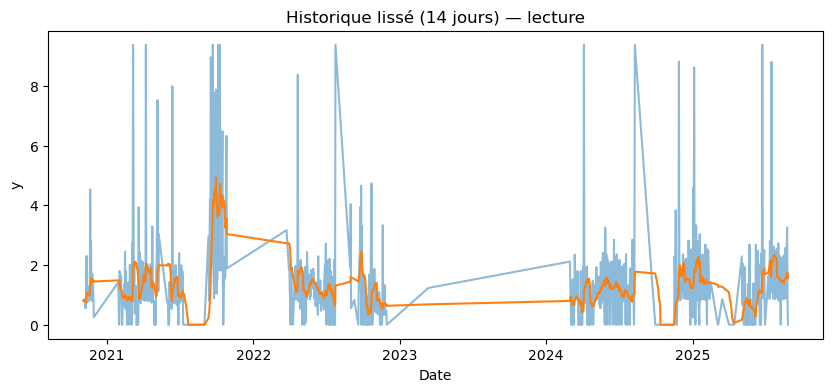

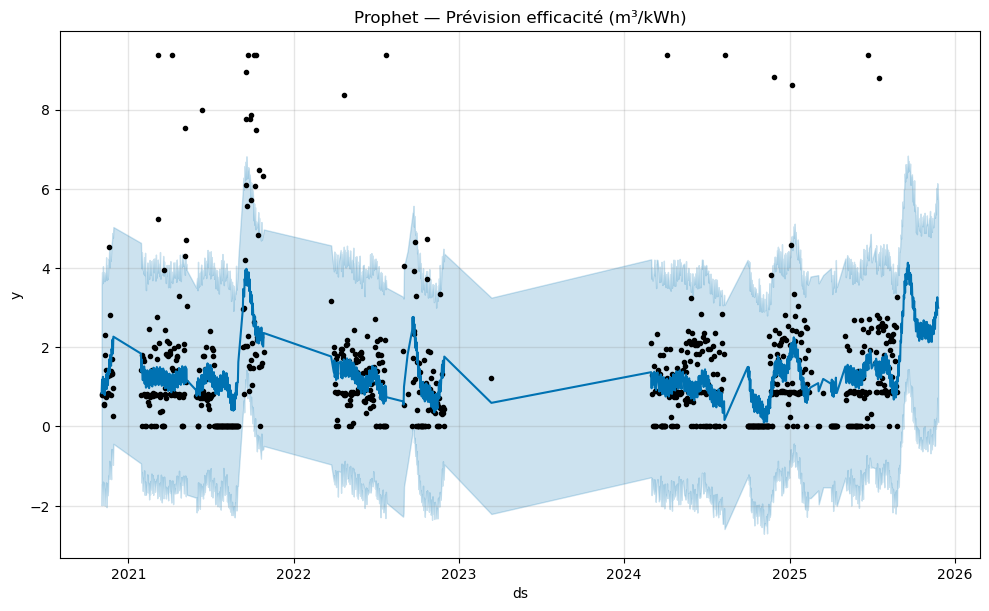

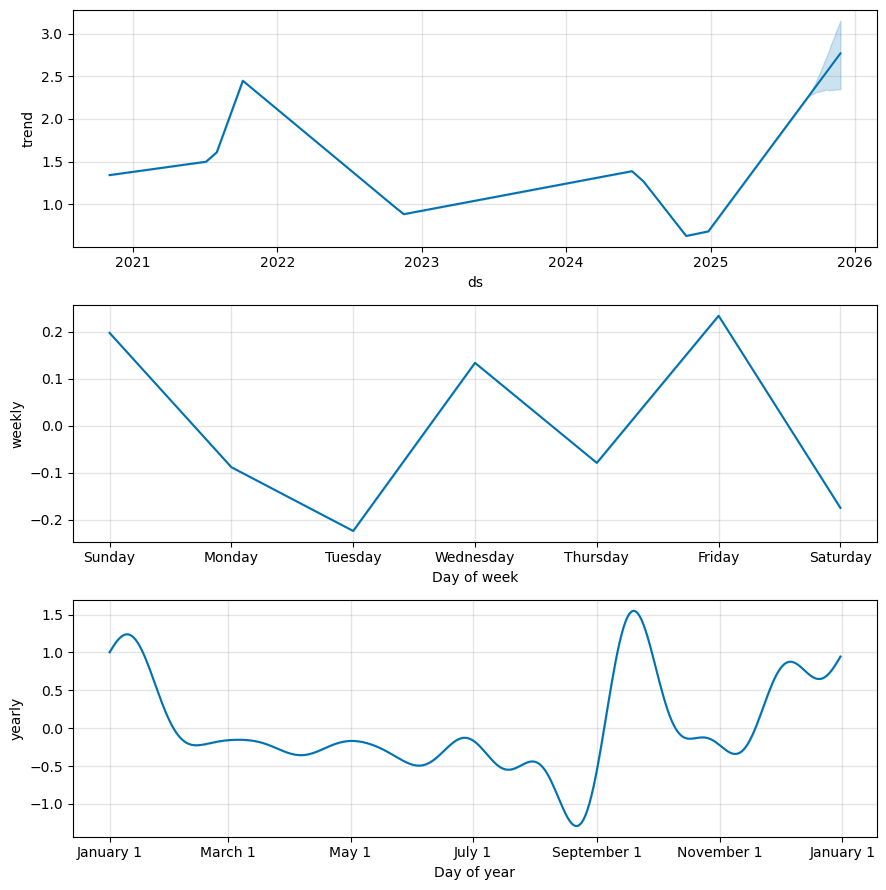

In [8]:

plt.figure(figsize=(10,4))
plt.plot(dfm["ds"], dfm["y"])
plt.title("Historique (winsorisé) — Efficacité m³/kWh")
plt.xlabel("Date"); plt.ylabel("y"); plt.show()

if ROLLING_WINDOW and ROLLING_WINDOW>1:
    plt.figure(figsize=(10,4))
    plt.plot(dfm["ds"], dfm["y"], alpha=0.5)
    plt.plot(dfm["ds"], dfm["y"].rolling(ROLLING_WINDOW, min_periods=1).mean())
    plt.title(f"Historique lissé ({ROLLING_WINDOW} jours) — lecture"); plt.xlabel("Date"); plt.ylabel("y")
    plt.show()

fig1 = m_final.plot(forecast)
plt.title("Prophet — Prévision efficacité (m³/kWh)"); plt.show()

fig2 = m_final.plot_components(forecast); plt.show()


## 9) Risque d'inefficacité (jours sous la cible)

Cible = 1.3511 m³/kWh
Risque (yhat < cible)        : 2.2% des jours
Risque pessimiste (upper<cible): 0.0%
Risque optimiste (lower<cible) : 97.8%


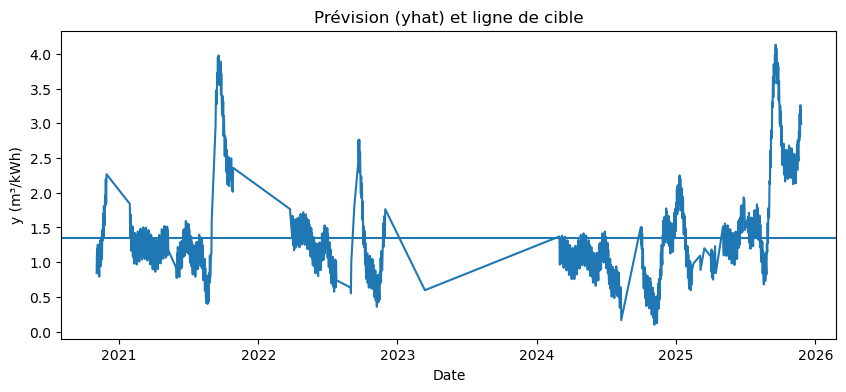

In [9]:

fcst_h = forecast[forecast["ds"] > dfm["ds"].max()].copy()
if len(fcst_h) == 0:
    print("⚠️ Pas de période future (FORECAST_HORIZON=0 ?)")
    risk  = risk_u = risk_l = np.nan
else:
    risk   = float((fcst_h["yhat"]       < target_eff).mean())
    risk_u = float((fcst_h["yhat_upper"] < target_eff).mean())
    risk_l = float((fcst_h["yhat_lower"] < target_eff).mean())

print(f"Cible = {target_eff:.4f} m³/kWh")
print(f"Risque (yhat < cible)        : {risk*100:.1f}% des jours")
print(f"Risque pessimiste (upper<cible): {risk_u*100:.1f}%")
print(f"Risque optimiste (lower<cible) : {risk_l*100:.1f}%")

plt.figure(figsize=(10,4))
plt.plot(forecast["ds"], forecast["yhat"])
plt.axhline(target_eff)
plt.title("Prévision (yhat) et ligne de cible"); plt.xlabel("Date"); plt.ylabel("y (m³/kWh)")
plt.show()


## 10) Rapport & Exports

In [10]:

lines = []
lines.append("# Rapport — Prophet optimisé (robuste) — Gombele")
lines.append(f"Observations: {len(dfm)} jours | Période: {dfm['ds'].min().date()} → {dfm['ds'].max().date()}")
lines.append(f"Cible (m³/kWh): {target_eff:.4f} (mode={TARGET_MODE})")
if isinstance(best, dict):
    lines.append(f"Meilleurs hyperparamètres: cps={best['cps']}, mode={best['mode']}, sps={best['sps']}")
    if 'score' in best:
        lines.append(f"SCORE~{best['score']:.6f} | MAPE~{best.get('mape', float('nan')):.4f} | band_rel~{best.get('band_rel', float('nan')):.4f}")
else:
    lines.append("Meilleurs hyperparamètres: non déterminés (fallback).")
if 'risk' in locals() and not np.isnan(risk):
    lines.append(f"Risque futur (yhat<cible): {risk*100:.1f}%  | pessimiste: {risk_u*100:.1f}% | optimiste: {risk_l*100:.1f}%")
else:
    lines.append("Risque futur: non évalué (pas de prévision).")

# Sauvegarde rapport
report_path = Path("rapport_prophet_optimise_robuste.txt")
with open(report_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

# Export prévision
export_cols = ["ds","yhat","yhat_lower","yhat_upper"]
out_fcst = Path("forecast_prophet_optimise_robuste.xlsx")
with pd.ExcelWriter(out_fcst, engine="openpyxl") as writer:
    forecast[export_cols].to_excel(writer, index=False, sheet_name="forecast")

print("✅ Rapport  :", report_path.resolve())
print("✅ Prévision:", out_fcst.resolve())


✅ Rapport  : C:\Users\Hp\3D Objects\tfc fac\proph\rapport_prophet_optimise_robuste.txt
✅ Prévision: C:\Users\Hp\3D Objects\tfc fac\proph\forecast_prophet_optimise_robuste.xlsx
